In [1]:
import sys 
sys.path.append('../src')
sys.path

import hydra
import torch
from src.diffusion_model_spec2mol import Spec2MolDenoisingDiffusion
from src.datasets import spec2mol_dataset
from src import utils
from omegaconf import OmegaConf
# Setup extra features, domain features, metrics etc. as in your main script
from src.diffusion.extra_features import DummyExtraFeatures, ExtraFeatures
from src.diffusion.extra_features_molecular import ExtraMolecularFeatures
from src.metrics.molecular_metrics_discrete import TrainMolecularMetricsDiscrete
from src.analysis.visualization import MolecularVisualization
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
# Load config from your config file (adjust path accordingly)
hydra.initialize(version_base='1.3', config_path="../configs")  # relative to your current working directory

# Compose the config by name
cfg = hydra.compose(config_name="config")

print(cfg.dataset)

{'name': 'neims_eval', 'remove_h': None, 'stats_dir': None, 'datadir': '../data/neims', 'filter': False, 'denoise_nodes': False, 'merge': 'downproject_4096', 'morgan_nbits': 2048, 'morgan_r': 2, 'split_file': '../data/neims/split.tsv', 'spec_features': 'peakformula', 'mol_features': 'fingerprint', 'subform_folder': '../data/neims/subformulae/subformulae_default/subforms', 'augment_data': False, 'remove_prob': 0.1, 'remove_weights': 'exp', 'inten_prob': 0.1, 'inten_transform': 'float', 'cls_type': 'ms1', 'magma_aux_loss': False, 'labels_file': '../data/neims/labels.tsv', 'spec_folder': '../data/neims/spec_files', 'cache_featurizers': False, 'set_pooling': 'cls', 'max_count': None, 'collated_pkl': True, 'collated_pkl_file': 'df_neims_gecko_3_9_22.pkl'}


In [3]:
# Initialize datamodule and dataset infos to build model correctly
datamodule = spec2mol_dataset.Spec2MolDataModule(cfg)
dataset_infos = spec2mol_dataset.Spec2MolDatasetInfos(datamodule, cfg)

domain_features = ExtraMolecularFeatures(dataset_infos=dataset_infos)
if cfg.model.extra_features is not None:
    extra_features = ExtraFeatures(cfg.model.extra_features, dataset_info=dataset_infos)
else:
    extra_features = DummyExtraFeatures()

dataset_infos.compute_input_output_dims(datamodule=datamodule, extra_features=extra_features, domain_features=domain_features)
train_metrics = TrainMolecularMetricsDiscrete(dataset_infos)
visualization_tools = MolecularVisualization(cfg.dataset.remove_h, dataset_infos=dataset_infos)

model_kwargs = {
    'dataset_infos': dataset_infos,
    'train_metrics': train_metrics,
    'visualization_tools': visualization_tools,
    'extra_features': extra_features,
    'domain_features': domain_features,
    'map_location': torch.device('cpu')
}

# Load the model from checkpoint
checkpoint_path = '../data/checkpoints/checkpoints/epoch=6.ckpt'
model = Spec2MolDenoisingDiffusion.load_from_checkpoint(checkpoint_path, **model_kwargs)

# Put model in evaluation mode
model.eval()

# Now you can run evaluation or inference here
# For example:
# trainer.test(model, datamodule=datamodule, ckpt_path=checkpoint_path)

print("Model loaded and in eval mode, ready for inference or evaluation.")
# Prepare batch (example)
batch = next(iter(datamodule.test_dataloader()))

100%|██████████| 166434/166434 [00:14<00:00, 11488.32it/s]
166434it [00:07, 23213.69it/s]
166434it [00:00, 7669465.96it/s]


Model loaded and in eval mode, ready for inference or evaluation.


In [ ]:
batch

In [ ]:
data = batch['graph']

# 1) Convert to dense
dense_data, node_mask = utils.to_dense(data.x, data.edge_index, data.edge_attr, data.batch)  # dense_data.X [B, N, Xdim], dense_data.E [B, N, N, Edim]

dense_data = dense_data.mask(node_mask)  # apply mask to dense data (if needed)

X, E = dense_data.X, dense_data.E
y = data.y.float()  # or your target y tensor

# 2) Optionally apply noise (or identity if just inference)
# If you want to skip noise, just use identity:
noisy_data = {'X_t': X, 'E_t': E, 'y_t': y, 'node_mask': node_mask}

# 3) Compute extra features
extra_data = extra_features(noisy_data)  # returns utils.PlaceHolder with X, E, y

print('noisy data: X_t, E_t, y_t: ', noisy_data['X_t'].shape, noisy_data['E_t'].shape, noisy_data['y_t'].shape)
print('extra_data.X: ', extra_data.X.shape)
print('node_mask: ', node_mask.shape)
with torch.no_grad():
    output, aux = model.encoder(batch)

    # Predict fingerprint (depending on `model.merge`)
    if model.merge == 'mist_fp':
        y = aux["int_preds"][-1]
    elif model.merge in ('merge-encoder_output-linear', 'merge-encoder_output-mlp'):
        y = model.merge_function(aux['h0'])
    elif model.merge == 'downproject_4096':
        y = model.merge_function(output)
    
        # Graph generation
    data = batch["graph"]
    data.y = y
    generated_mols = [list() for _ in range(len(data))]
    for _ in range(model.test_num_samples):
        for idx, mol in enumerate(model.sample_batch(data)):
            generated_mols[idx].append(mol)

    

noisy data: X_t, E_t, y_t:  torch.Size([24, 26, 8]) torch.Size([24, 26, 26, 5]) torch.Size([24, 2048])
extra_data.X:  torch.Size([24, 26, 6])
node_mask:  torch.Size([24, 26])


In [20]:
torch.save(y, 'predicted_fingerprints.pt')


In [21]:
import pickle
with open("generated_mols.pkl", "wb") as f:
    pickle.dump(generated_mols, f)

In [27]:
with open('batch_names.txt', 'w+') as file:
    for name in batch['names']:
        file.writelines(name + '\n')

In [23]:
len(generated_mols)

24

In [41]:
import numpy as np
with open('fp.txt', 'w+') as file:
    for tens in y:
        str_out = ''
        for el in (np.array(tens) >= 0.5).astype(np.uint8):
            str_out += f'{int(el)} '
        file.writelines(str_out + '\n')

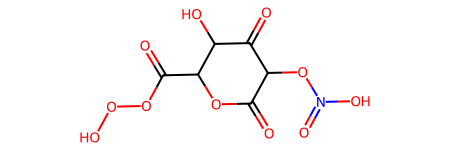

In [47]:
generated_mols[0][4]